# Import modules

In [1]:
from collections import Counter

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set()

# Import data generated from ```01_get_data.py```

In [2]:
df = pd.read_csv('lyrics.csv')

# dop song duplicates from the same artist
df.drop_duplicates(subset=['artist', 'title'], inplace=True)

# tokenize, remove stopwords, stemming and lemming
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
df['tokens'] = df.lyrics.apply(
    lambda x: [ps.stem(w) 
    for w in word_tokenize(x.lower()) 
    if 
         (not w in stop_words) and
         (not "'" in w) and
         (len(w) > 1)
    ])

# count words
df['word_count'] = df.tokens.apply(lambda x: len(x))

# count unique words
df['unique_word_count'] = df.tokens.apply(lambda x: len(set(x)))

# remove outliers
df = df[df.word_count>10]

# set decade
df['year'] = df.year.astype(int)
df['1990s'] = np.where(
                ((1990<=df.year) & (df.year <=1999)),
                '1990s',
                None
            )

df['2000s'] = np.where(
                ((2000<=df.year) & (df.year <=2009)),
                '2000s',
                None
            )

df['2010s'] = np.where(
                ((2010<=df.year) & (df.year <=2019)),
                '2010s',
                None
            )

df['2020s'] = np.where(
                ((2020<=df.year) & (df.year <=2029)),
                '2020s',
                None
            )

df['decade'] = df['1990s'].combine_first(df['2000s']).combine_first(df['2010s']).combine_first(df['2020s'])

# drop unused columns
df = df.drop(columns=['1990s', '2000s', '2010s', '2020s'])

df

,artist,album,title,lyrics,year,tokens,word_count,unique_word_count,decade
0,Nightwish,Angels Fall First,Elvenpath,(In the sheltering shade of the forest \n Call...,1996,"[shelter, shade, forest, call, calm, silenc, a...",151,112,1990s
1,Nightwish,Angels Fall First,Beauty And The Beast,Remember the first dance we shared? \n Recall ...,1996,"[rememb, first, danc, share, recal, night, mel...",101,78,1990s
2,Nightwish,Angels Fall First,The Carpenter,Who are you? \n Man condemned to shine a salva...,1996,"[man, condemn, shine, salvat, throughout, cent...",90,51,1990s
3,Nightwish,Angels Fall First,Astral Romance,A nocturnal concerto \n Candlelight whispers m...,1996,"[nocturn, concerto, candlelight, whisper, go, ...",84,83,1990s
4,Nightwish,Angels Fall First,Angels Fall First,An angelface smiles to me \n Under a headline ...,1996,"[angelfac, smile, headlin, tragedi, smile, use...",91,66,1990s
...,...,...,...,...,...,...,...,...,...
1724,Visions of Atlantis,The Deep & the Dark,The Last Home,Here it comes \n One of my saddest days \n Pai...,2018,"[come, one, saddest, day, pain, tomorrow, wo, ...",86,45,2010s
1725,Visions of Atlantis,The Deep & the Dark,The Grand Illusion,Love is a lie \n Called me to wander \n Truste...,2018,"[love, lie, call, wander, trust, quick, wonder...",92,46,2010s
1726,Visions of Atlantis,The Deep & the Dark,Dead Reckoning,Trapped inside my dreams \n I try to leave \n ...,2018,"[trap, insid, dream, tri, leav, true, world, s...",89,50,2010s
1727,Visions of Atlantis,The Deep & the Dark,Words Of War,With our lives at higher tension \n And fear i...,2018,"[live, higher, tension, fear, everi, heart, cl...",117,58,2010s


# Explore relationship

From this plot, we can see that there is a correlation between ```word_count``` and ```unique_word_count```, that is, they go in the same direction. The higher the word_count, the higher unique_word_count and vice versa.

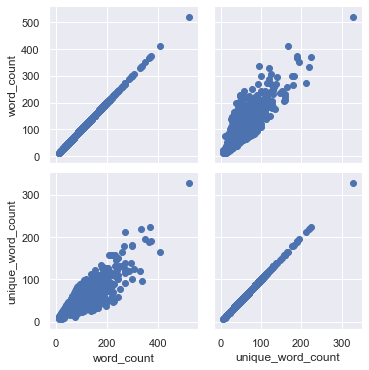

In [3]:
g = sns.PairGrid(df[['word_count', 'unique_word_count']])
g.map(plt.scatter)

# Boxplot

We can use either ```word_count``` or ```unique_word_count```, since they go in the same direction, except the values from ```unique_word_count``` will be higher, but it is proportional to ```word_count```

Boxplot represents data distribution in quartiles, in which the the box-y area is in middle of the distribution (think of a bell curve, the box-y area is right around the peak, padded a bit to left and right),  and the line-y area is the left/right edge of the curve. The scattered points are outliers, meaning they are too different from the rest of the dataset.

From this figure, we can see that Nightwish has a very large outlier, seeing one data point is in 1000 range. Myrath has the least words, and Linkin Park has the most. For Linkin Park, it can be attributed to the fact that their lyrics contain rap verses. As for Nightwish outliers, some of their songs contain very lengthy spoken parts.

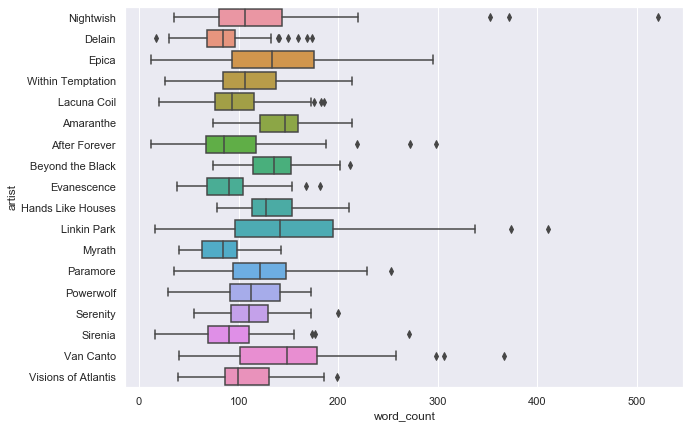

In [4]:
plt.figure(figsize=(10,7))
sns.boxplot(x="word_count", y="artist", data=df, orient='h')

# Most common words

In this step, we count how much a word occur per dataset, then plot a bar graph for each. For the bands I usually listen to, each album has a theme, so it's very probable that each album would have different set of most common words.

/Users/kahnwong/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


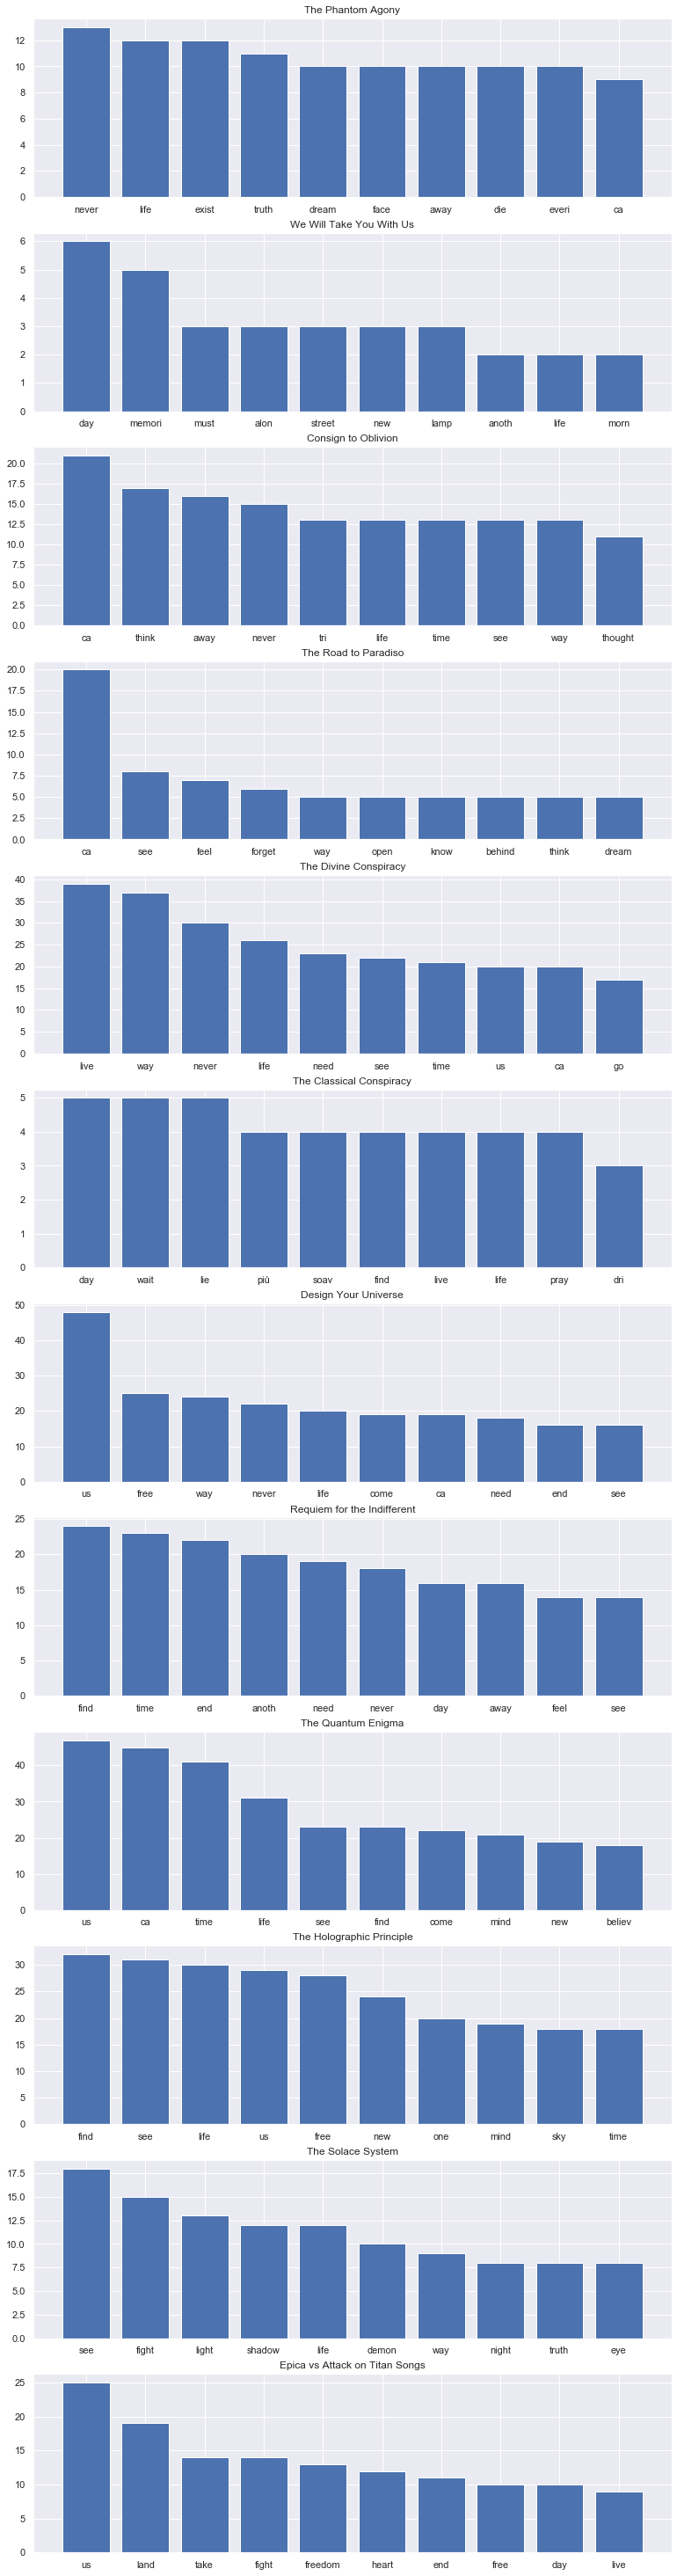

In [5]:
def word_vector(df):
    ########## make a list of all unique words
    all_words = []
    for i in df.tokens:
        all_words.extend(set(i))

    all_words = set(all_words)
    ########## make tf/idf
    word_count = df.tokens.apply(lambda x: Counter(x))
    word_count = pd.DataFrame(word_count.to_list())
    ########## get sum for each unique word
    wordcount_sum = []
    for i in word_count.columns:
        wordcount_sum.append({
            'word': i,
            'count': word_count[i].sum()
        })

    wordcount_sum = pd.DataFrame(wordcount_sum)
    wordcount_sum = wordcount_sum[wordcount_sum['count']!=0]
    wordcount_sum.sort_values(by='count', ascending=False, inplace=True)
    ##########

    return wordcount_sum.head(10)

# get wordcount for each group, this way the word_vector function is not getting messy
wordcount_group = []
################# adjust filters here
artist = 'Epica'
group = 'album' # album, decade
#################
df_temp = df[df.artist==artist]
for i in df_temp[group].unique():
    chunk = word_vector(df_temp[df[group]==i])
    chunk[group] = i
    wordcount_group.append(chunk)

wordcount_group = pd.concat(wordcount_group)

# plot
fig, axs = plt.subplots(len(wordcount_group[group].unique()), figsize=(13,53)) # adjust figure size here if it's too cramped
for index, i in enumerate(wordcount_group[group].unique()):
    temp = wordcount_group[wordcount_group[group]==i]
    axs[index].bar(temp['word'], temp['count'])
    axs[index].set_title(i)

In [6]:
def display_topics(model, feature_names, no_top_words):
    topic_words = []
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        topic = (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('\t' + topic)
        topic_words.append(topic)
        
    return topic_words

# define temp dataframe here
temp = df.query('artist == "Visions of Atlantis" or\
                artist == "Lacuna Coil" or\
                artist == "Epica" or\
                artist == "Nightwish"')

# define parameters
no_features = 1000
no_topics = len(temp.artist.unique()) # set album count as number of topics
no_top_words = 15

# create word matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(temp.lyrics)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

print('========== NMF ==========')
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
topic_words = display_topics(nmf, tfidf_feature_names, no_top_words)

========== NMF ==========
Topic 0:
	ll time life way light come live free just feel inside ve day let world
Topic 1:
	love heart night wish forever hate soul dream oh art rest heaven need kiss lust
Topic 2:
	away run far stay inside journey dream fade just wash felt destruction escape falling walked
Topic 3:
	don know wanna want just feel say care hate goes cause liar let look reason


In [7]:
print('========== LDA ==========')

lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)
topic_words = display_topics(lda, tfidf_feature_names, no_top_words)

========== LDA ==========
Topic 0:
	distance don beautiful let today cold look guide read world way faith wish mind heart
Topic 1:
	est tale feels talking drives wall wishmaster disciple bone mad searching free master apprentice sing
Topic 2:
	love heart ll hearts time world fight let come night know shadows try eyes mind
Topic 3:
	leaving ll healing endless sed died walk desire life nos ne moment die nostra like


I think NMF performs better in this case 😆